# Using TensorNet (Basic)

This notebook will demonstrate some of the core functionalities of TensorNet:

- Creating and setting up a dataset
- Augmenting the dataset
- Creating and configuring a model and viewing its summary
- Defining an optimizer and a criterion
- Setting up callbacks
- Training and validating the model
- Displaying plots for viewing the change in accuracy during training

# Installing Packages

In [ ]:
!pip install --upgrade --no-cache-dir torch-tensornet

# Imports
Importing necessary packages and modules

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

from tensornet.data import CIFAR10
from tensornet.models import mobilenet_v2
from tensornet.models.loss import cross_entropy_loss
from tensornet.models.optimizer import sgd
from tensornet.utils import initialize_cuda, plot_metric
from tensornet.engine.ops import ModelCheckpoint
from tensornet.engine.ops.lr_scheduler import reduce_lr_on_plateau

## Set Seed and Get GPU Availability

In [2]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(1)  # random seed is set to 1

GPU Available? True


## Setup Dataset

Downloading and initializing `CIFAR-10` dataset and applying the following augmentations:
- Horizontal Flip
- Random Rotation
- Cutout Augmentation

In [3]:
dataset = CIFAR10(
    train_batch_size=64,
    val_batch_size=64,
    cuda=cuda,
    num_workers=4,
    horizontal_flip_prob=0.2,
    rotate_degree=20,
    cutout_prob=0.3,
    cutout_dim=(8, 8),
)

Extracting /content/tensornet/data/datasets/.cache/cifar-10-python.tar.gz to /content/tensornet/data/datasets/.cache
Files already downloaded and verified


## Data Visualization
Let's see how our data looks like. This information will help us decide the transformations that can be used on the dataset.

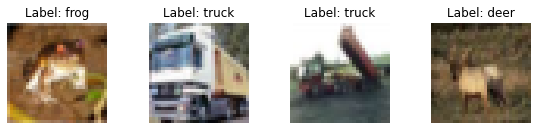

In [4]:
# Fetch data
classes = dataset.classes
sample_data, sample_targets = dataset.data()

# Set number of images to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    axs[i].axis('off')
    axs[i].set_title(f'Label: {classes[sample_targets[i]]}')
    axs[i].imshow(sample_data[i])

## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [5]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

We'll download a pretrained ResNet18 model and train it on our dataset using fine-tuning.

In [7]:
model = mobilenet_v2(pretrained=True).to(device)  # Create model
model.summary(dataset.image_size)  # Display model summary

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-14             [-1, 

# Model Training and Validation

- Loss Function: `Cross Entropy Loss`
- Optimizer: `SGD`
- Callbacks: `Model Checkpoint` and `Reduce LR on Plateau`

In [8]:
criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd(model)  # Create optimizer with deafult learning rate

# Create callbacks
checkpoint_path = 'checkpoints'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy'),
    reduce_lr_on_plateau(optimizer, factor=0.2, patience=2, min_lr=1e-6),
]

In [9]:
model.fit(
    train_loader,
    optimizer,
    criterion,
    device=device,
    epochs=10,
    val_loader=val_loader,
    callbacks=callbacks,
    metrics=['accuracy'],
)

Epoch 1:
782/782 [========] - 30s 39ms/step - loss: 1.4347 - accuracy: 46.9997
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0162, accuracy: 65.59

Epoch 2:
782/782 [========] - 30s 39ms/step - loss: 0.8717 - accuracy: 69.0421
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0110, accuracy: 75.27

Epoch 3:
782/782 [========] - 31s 39ms/step - loss: 0.7492 - accuracy: 73.5877
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0112, accuracy: 75.26

Epoch 4:
782/782 [========] - 31s 40ms/step - loss: 0.6778 - accuracy: 76.0332
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0095, accuracy: 79.06

Epoch 5:
782/782 [========] - 31s 39ms/step - loss: 0.6273 - accuracy: 78.2375
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0089, accuracy: 80.71

Epoch 6:
782/782 [========] - 30s 39ms/step - loss: 0.5841 - accuracy: 79.8276
Validation set (took 0 minutes, 2 seconds): Average loss: 0.0130, accuracy: 76.22

Epoch 7:
782/782 [========] 

## Result Analysis

Displaying the change in accuracy of the training and the validation set during training

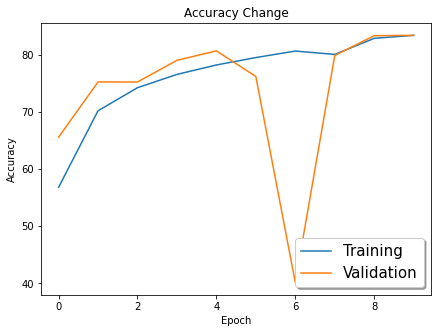

In [10]:
plot_metric({
    'Training': model.learner.train_metrics[0]['accuracy'],
    'Validation': model.learner.val_metrics[0]['accuracy']
}, 'Accuracy')